In [13]:
import re
import sys
import os
import os.path
sys.path.append('../python')
import latex_plots

import numpy as np
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 600
%matplotlib inline

import matplotlib.pyplot as plt



import plot_info
from plot_info import showAndSave
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import copy
import json
import traceback
with open('structure_functions_functionals_full_time_averaged_configs.json') as f:
    configurations = json.load(f)

def for_each_config(f):
    oldPrefix = copy.deepcopy(showAndSave.prefix)
    for conf in configurations.keys():
        
        plot_info.console_log(conf)
        headline(configurations[conf]['name'])
        showAndSave.prefix = oldPrefix + conf
        try:
            f(configurations[conf])
        except Exception as e:
            message = "Skipping {fname} on {conf} ({confname})\n\tReason: {reason}\nTraceback: {traceback}".format(fname=str(f),
                                                                                                       conf=conf, 
                                                                                                       confname=configurations[conf]['name'],
                                                                                                       reason=str(e),
                                                                                                     traceback=traceback.format_exc())
            plot_info.console_log(message)
            print(message)
            plt.close('all')
    showAndSave.prefix=oldPrefix

plot_info.set_notebook_name("structure_variance.ipynb")

In [2]:
def headline(text):
    display(HTML("<h1>%s</h1>"%text))
def h2(text):
    display(HTML("<h2>%s</h2>"%text))
def h3(text):
    display(HTML("<h3>%s</h3>"%text))
def h4(text):
    display(HTML("<h4>%s</h4>"%text))
def h5(text):
    display(HTML("<h4>%s</h4>"%text))

In [3]:
def readnetcdf4(filename, variable,sample):
    
    with netCDF4.Dataset(filename) as f:
        return f.variables[f'sample_{sample}_{variable}'][:,0,0]
    
def get_number_of_samples(filename):
    max_sample = 0
    with netCDF4.Dataset(filename) as f:
        for v in f.variables.keys():
            match = re.search(r'sample_(\d+)_', v)
            if match:
                sample = int(match.group(1))
                max_sample = max(sample, max_sample)
    return max_sample+1

def upscale(d, r):

    while d.shape[0] < r:
       
        d = np.repeat(d,2,0)
    return d


def plotscalings(d,d_var, r,title, exponent_mean, exponent_var):
    N = len(d)
    H = np.linspace(0, 64./2048,N)
   
    poly = np.polyfit(np.log(H[1:]), np.log(d[1:]),1)
    
        
    fig = plt.figure(0)
    plt.title(title)
    ax = plt.gca()
    
    p = ax.errorbar(H[1:] ,d[1:], yerr=np.sqrt(d_var[1:]), label='$N=%d$'%r)
    ax.set_xscale("log", basex=2)
    ax.set_yscale("log", basey=2)
    ax.loglog(H[1:], np.exp(poly[1])*H[1:]**(poly[0]), '--',
              label=f'$\\mathcal{{O}}(h^{{{poly[0]:.2f}\\pm{np.sqrt(exponent_var):.3f}}})$',
              color=p[0].get_color(), basex=2, basey=2)
    box = ax.get_position()
    
    
    ax.grid(True)

def estimate_exponents(samples, resolution):
    exponent = []
    constants= []
    H = np.linspace(0, 32.0/1024., int(32*resolution/1024))
    for sample in samples:
        poly = np.polyfit(np.log(H[1:]), np.log(sample[1:]), 1)
        
        exponent.append(poly[0])
        constants.append(np.exp(poly[1]))
    return exponent,  constants


def getlineintegral(filename, variables, resolution, p):
    all_samples = []
    for sample in range(get_number_of_samples(filename)):
        structure = np.zeros(int(32*resolution/1024))
        for variable in variables:
            d = readnetcdf4(filename, variable, sample)
            dx = 1.0/resolution
            
            for h in range(1,len(d)):
                d[h] += d[h-1]
            for h in range(1,len(d)):
                d[h] /=(2*h+1)**2
                
            structure += d
        all_samples.append(structure**(1.0/p))
    exponents, constants = estimate_exponents(all_samples, resolution)
            
    return np.mean(all_samples, 0), np.var(all_samples, 0), np.mean(constants), np.var(constants), np.mean(exponents), np.var(exponents)

def get_time(filename):
    with netCDF4.Dataset(filename) as f:
        return f.variables['time'][0]
    

def legend_fixed_right():
    # with the errorbar, the ordering of the legend can be a bit weird, this function fixes that
    ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if len(handles)%2 != 0:
        raise ValueError(f"Expected divisble by two! Got {len(handles)} entries in legend")
        
        
    new_handles = []
    new_labels = []

    for i in range(len(handles)//2):
        new_handles.append(handles[len(handles)//2+i])
        new_handles.append(handles[i])
        
        new_labels.append(labels[len(handles)//2+i])
        new_labels.append(labels[i])
        
    ax.legend(new_handles, new_labels,
              loc='lower right')
             # loc='center left')#, bbox_to_anchor=(1, 0.5))
    

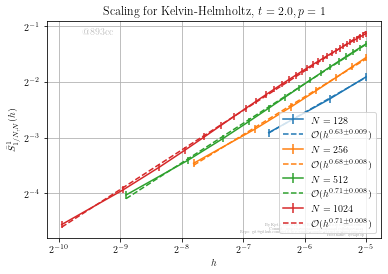

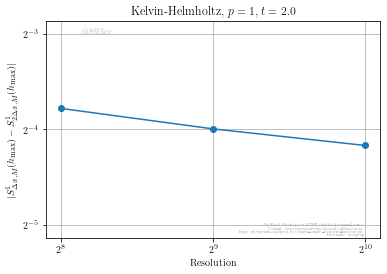

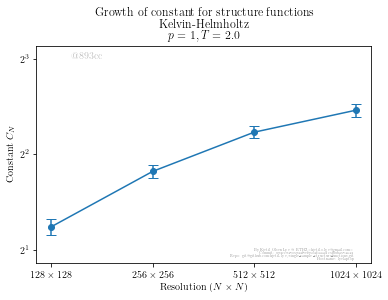

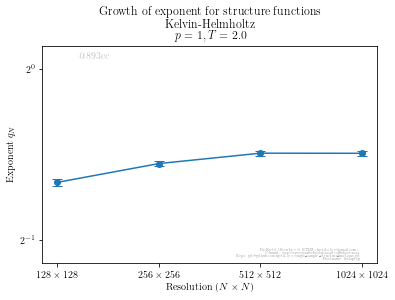

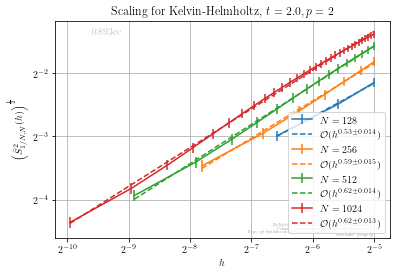

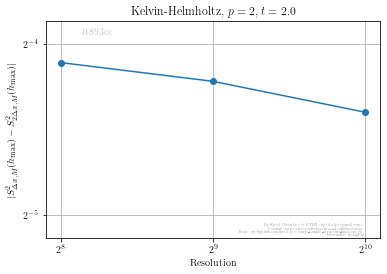

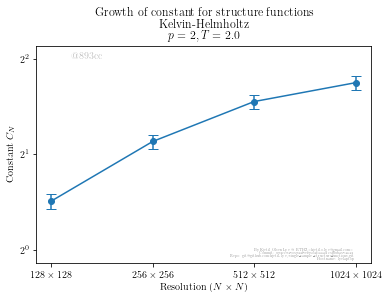

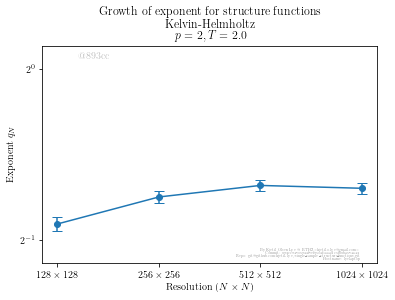

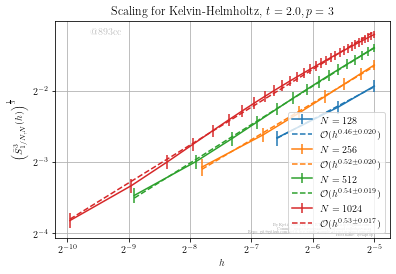

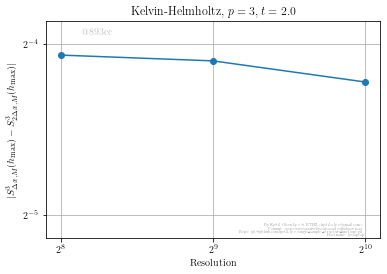

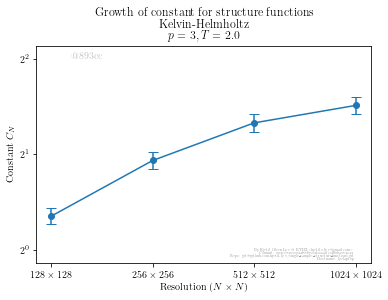

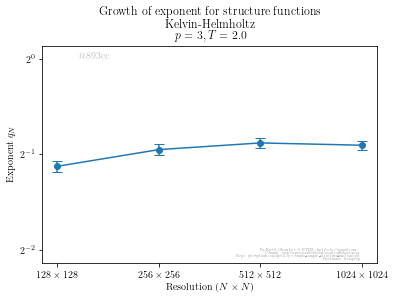

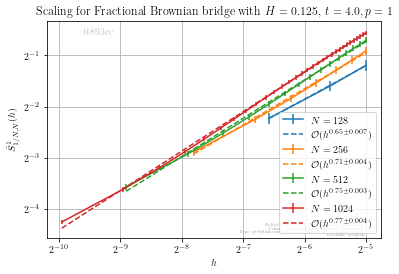

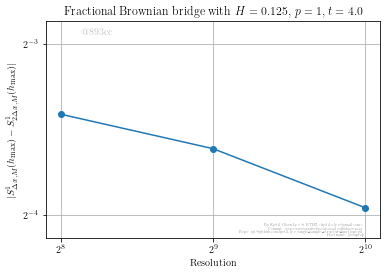

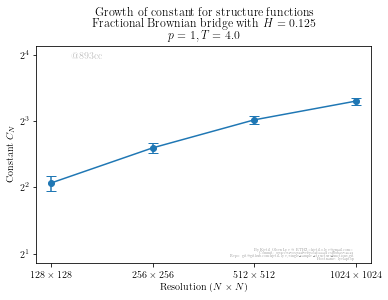

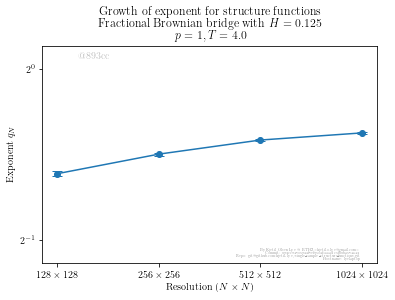

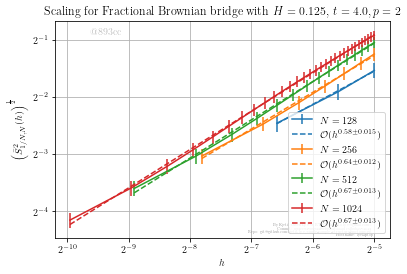

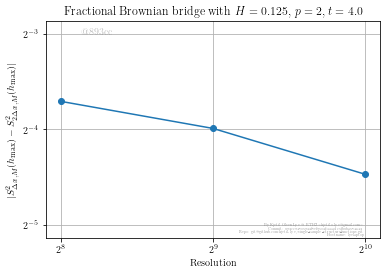

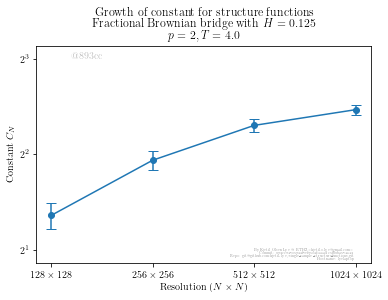

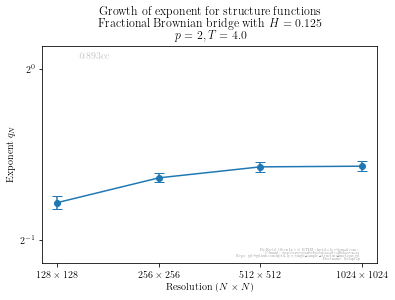

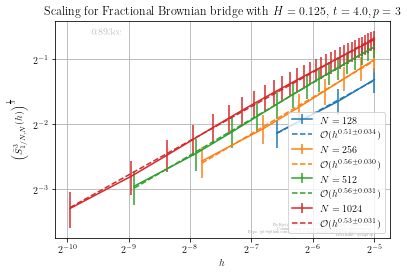

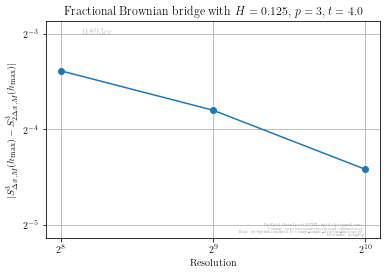

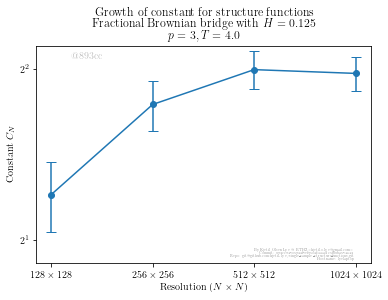

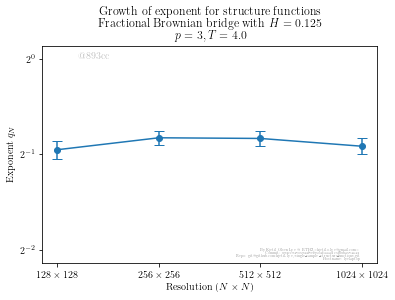

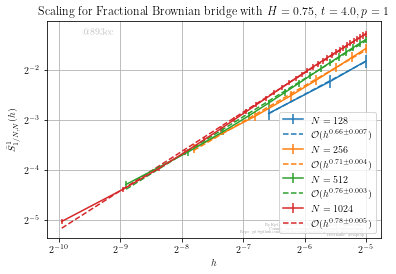

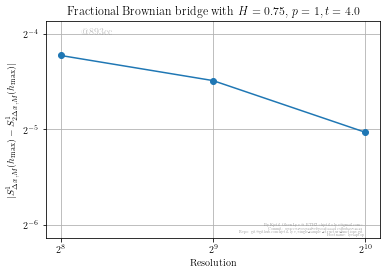

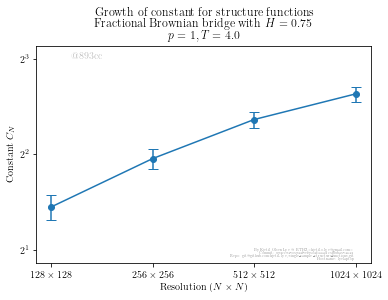

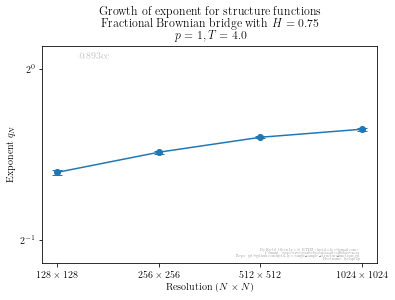

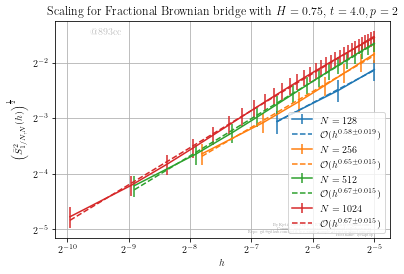

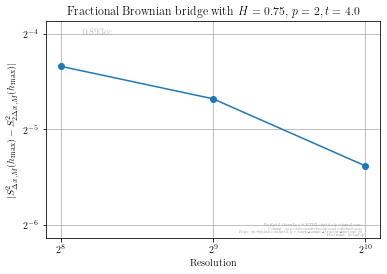

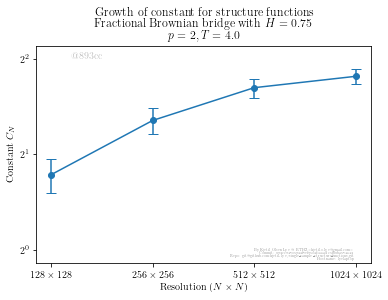

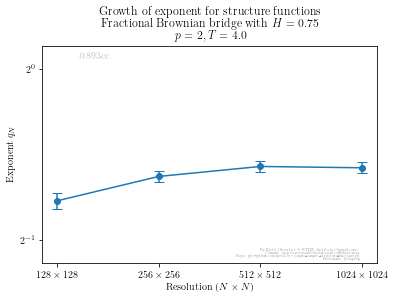

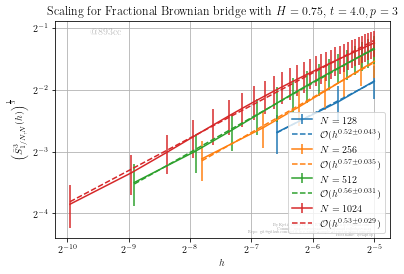

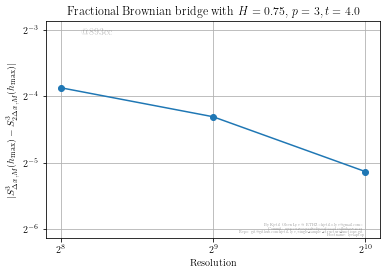

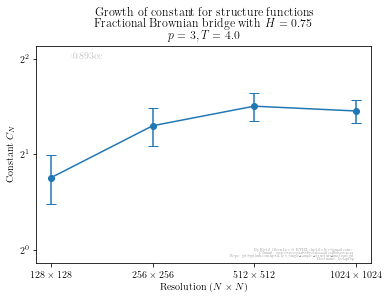

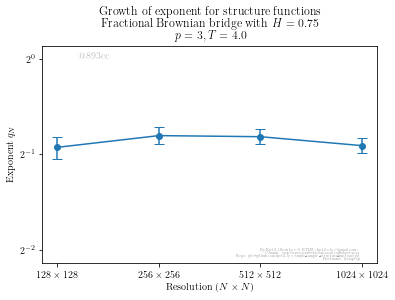

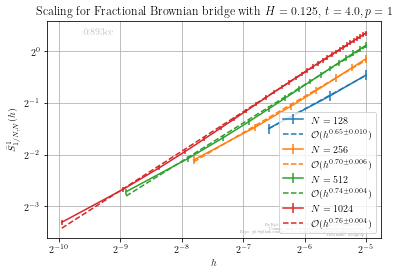

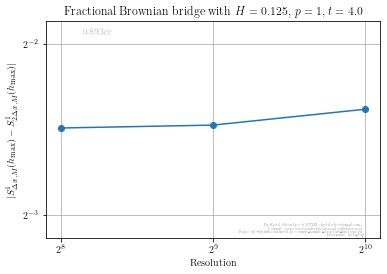

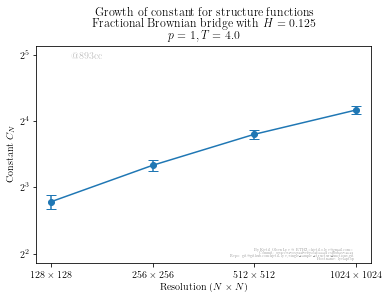

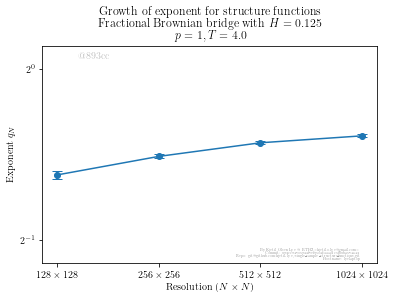

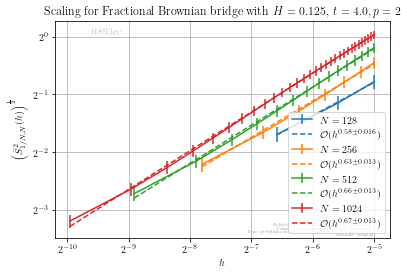

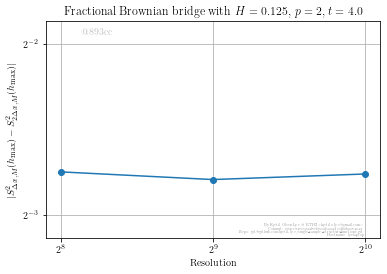

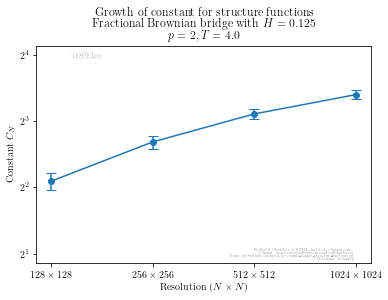

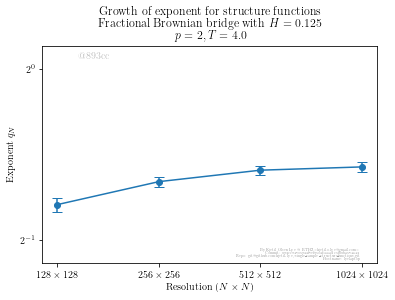

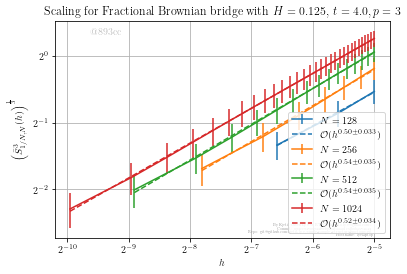

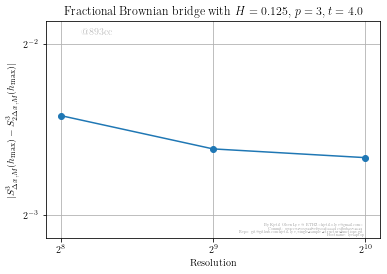

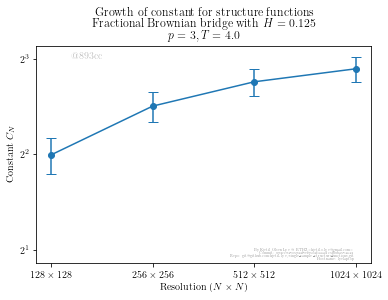

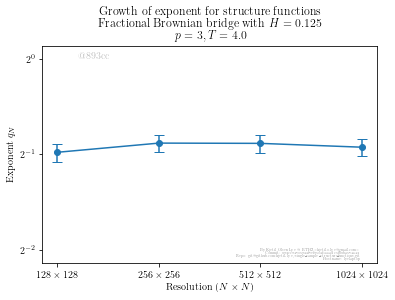

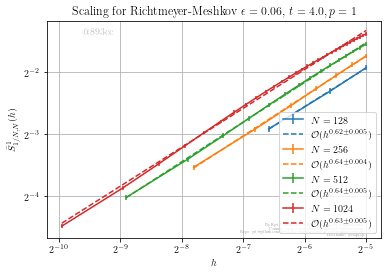

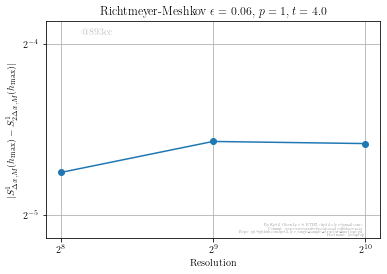

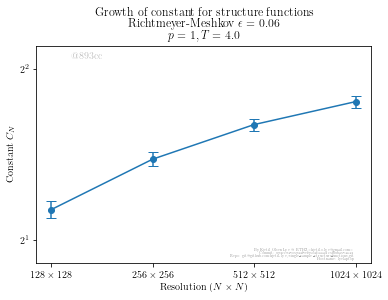

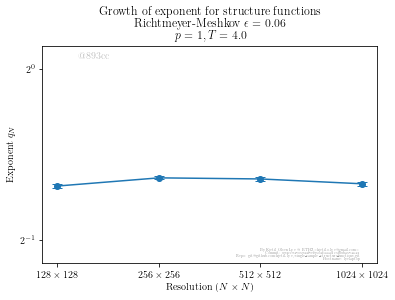

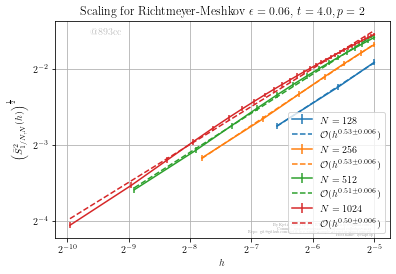

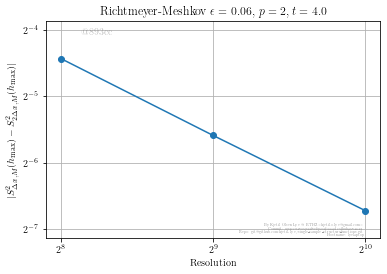

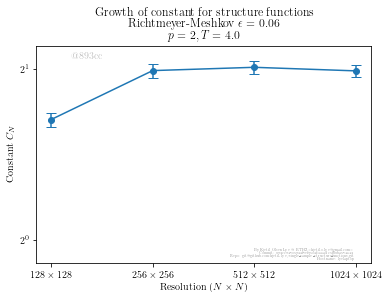

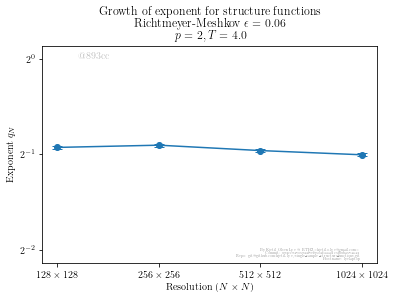

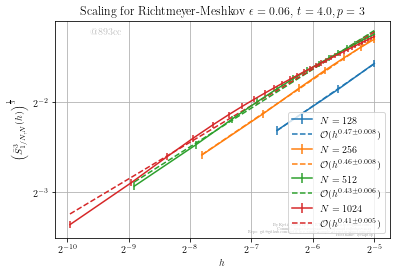

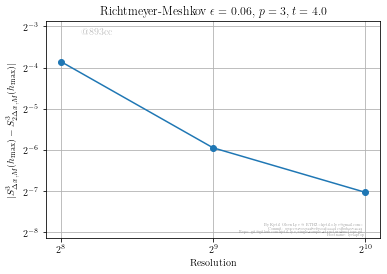

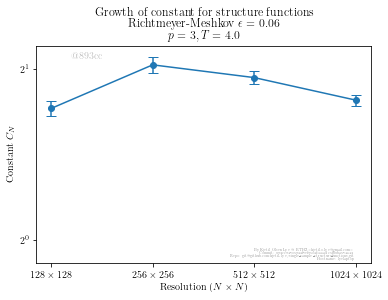

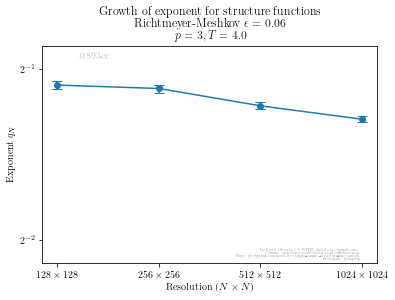

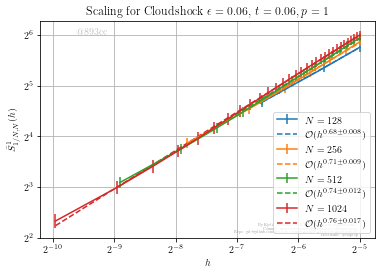

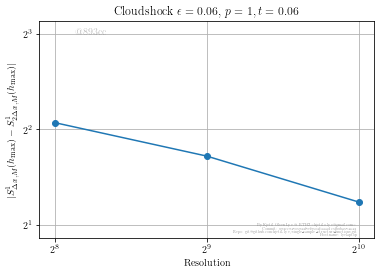

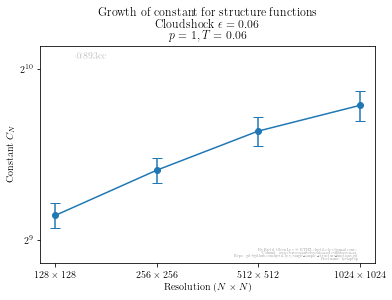

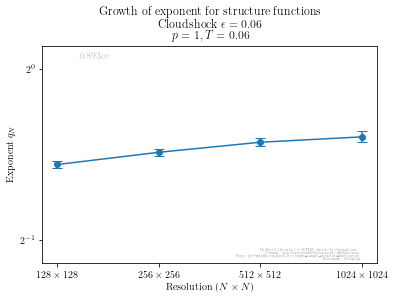

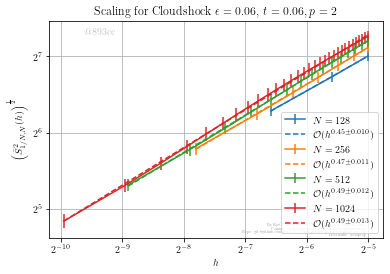

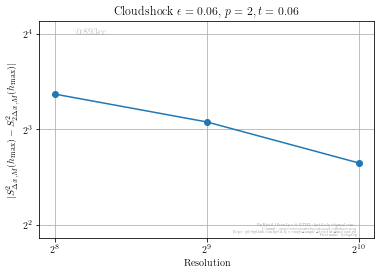

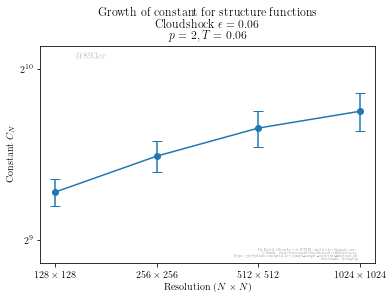

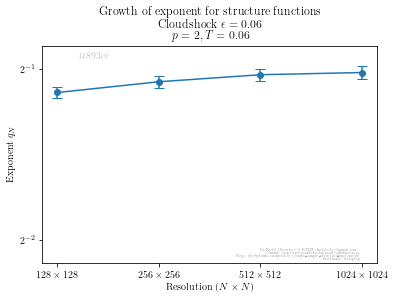

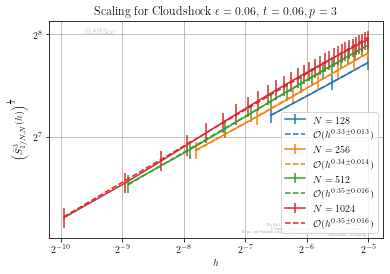

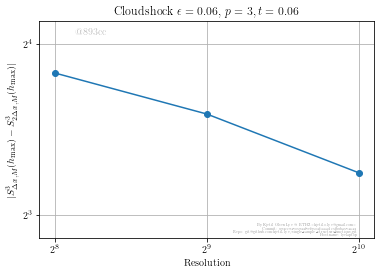

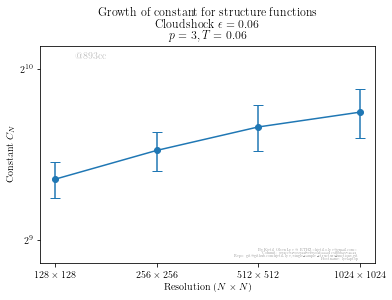

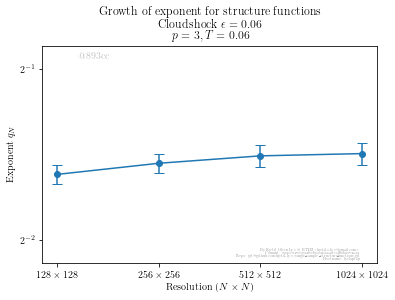

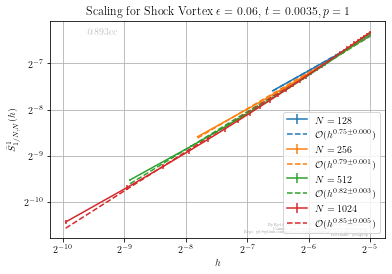

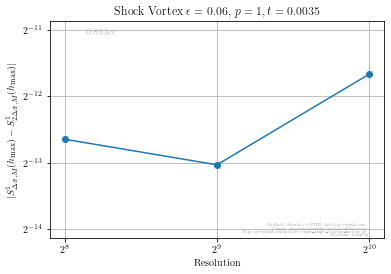

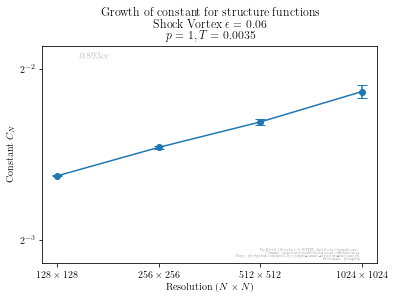

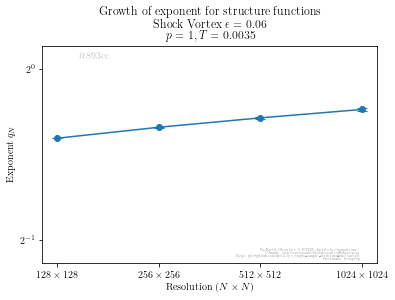

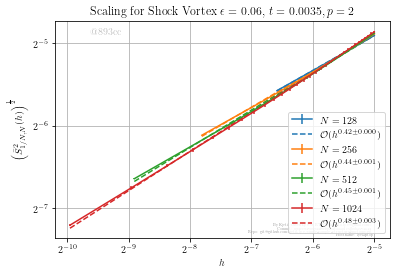

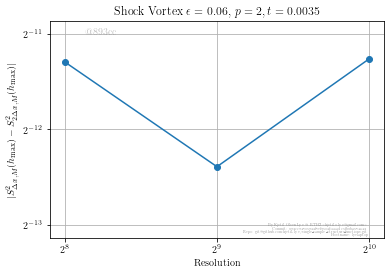

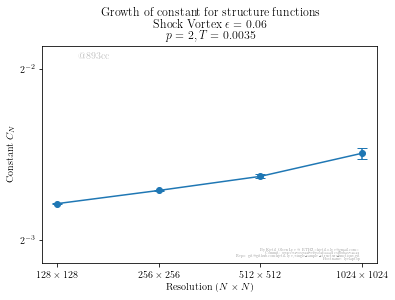

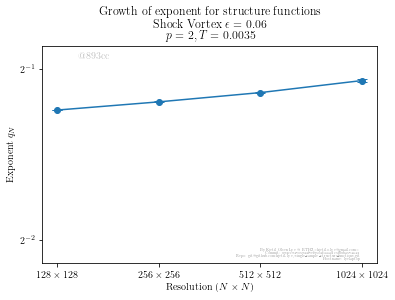

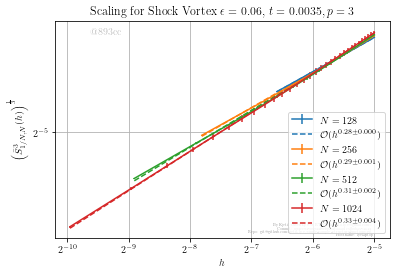

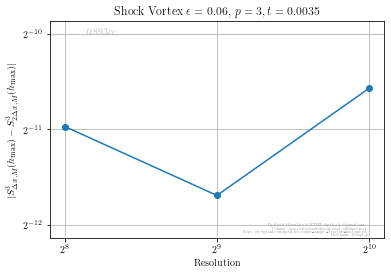

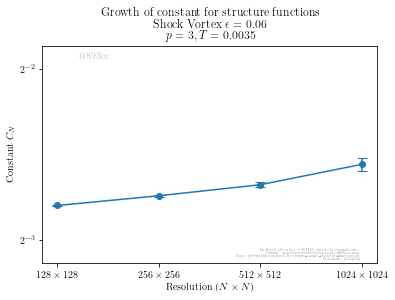

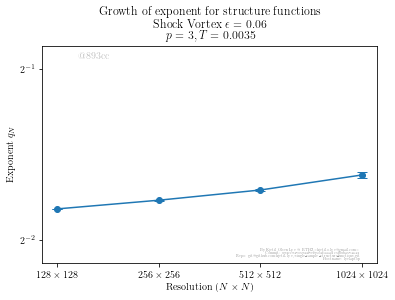

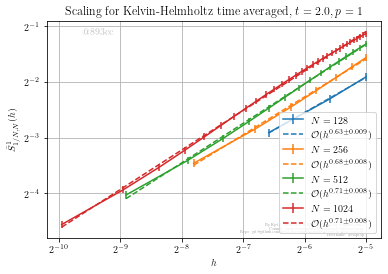

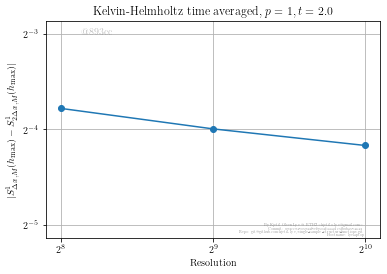

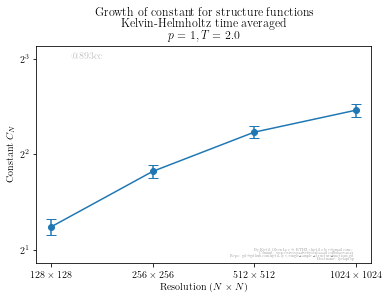

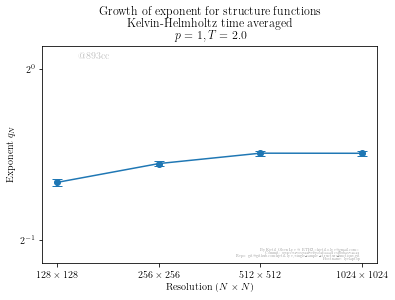

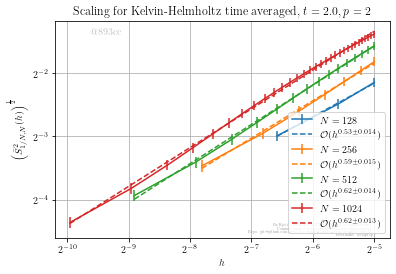

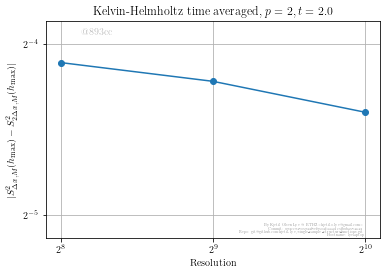

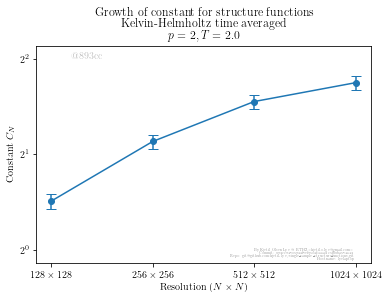

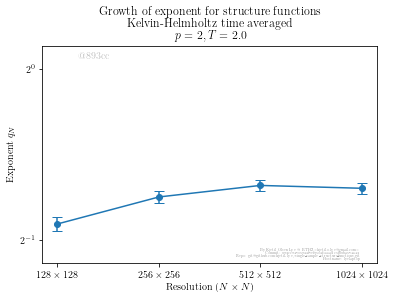

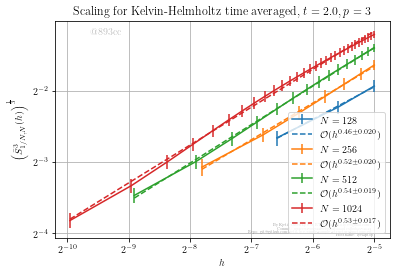

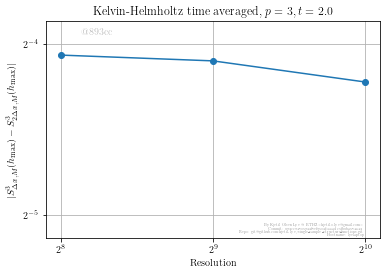

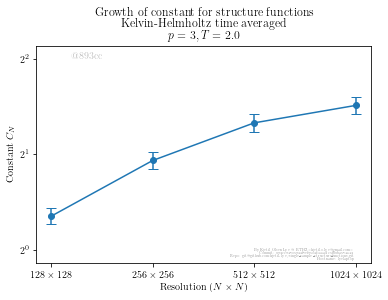

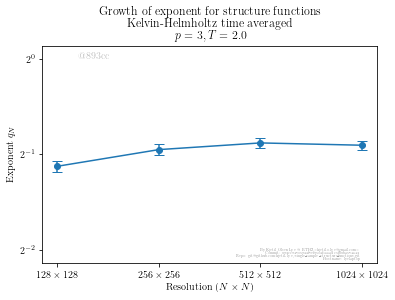

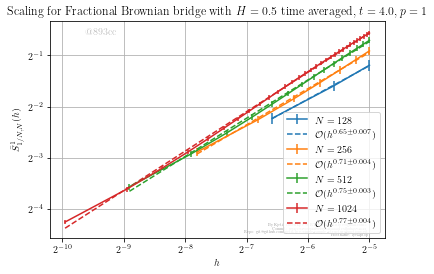

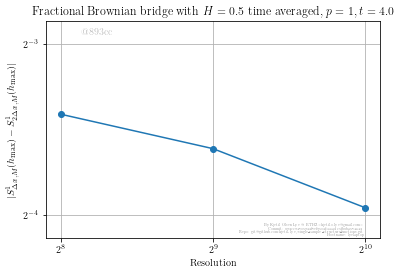

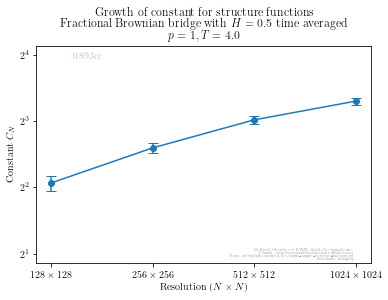

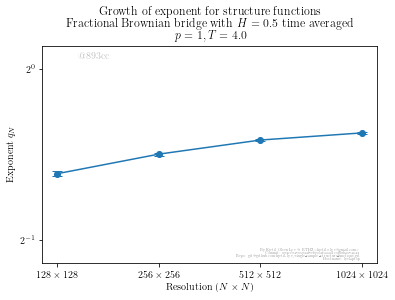

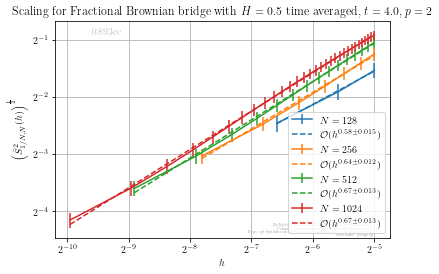

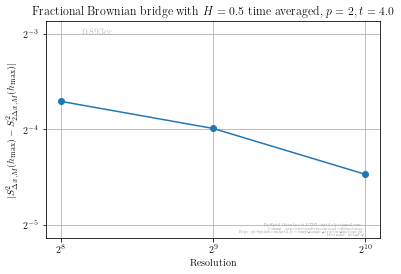

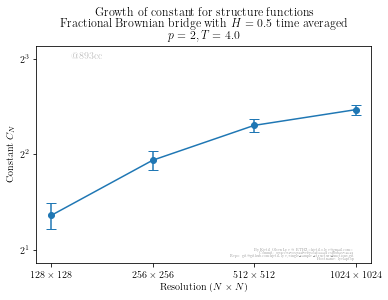

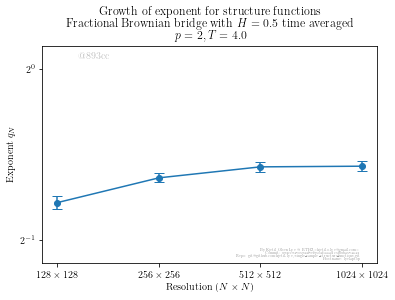

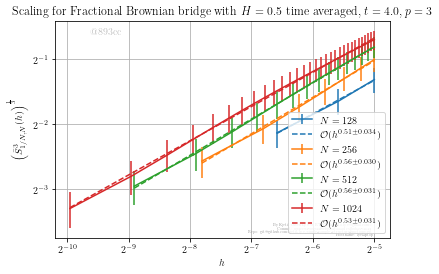

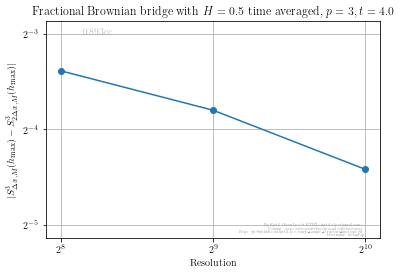

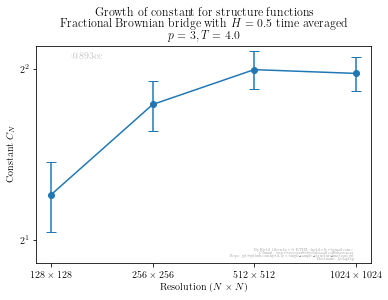

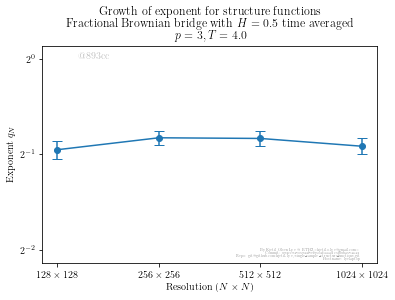

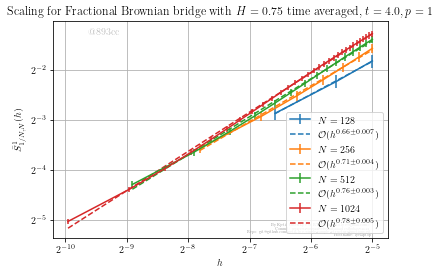

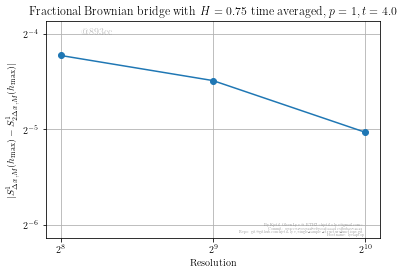

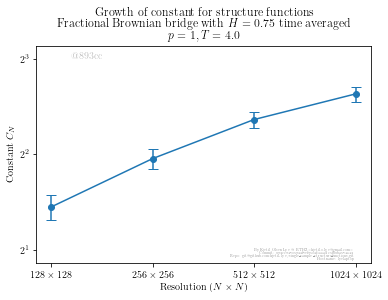

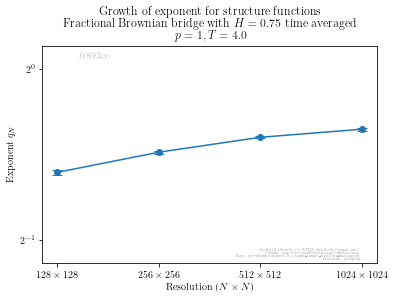

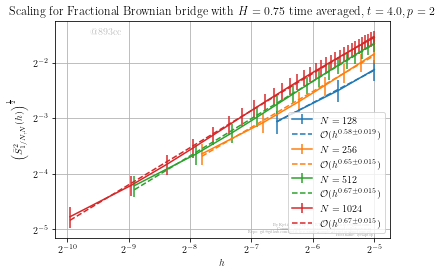

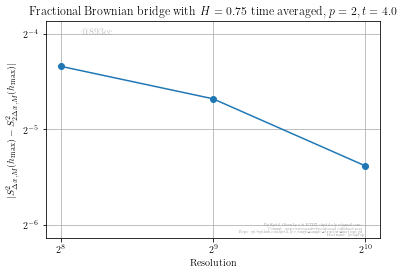

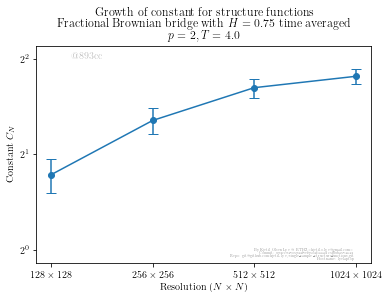

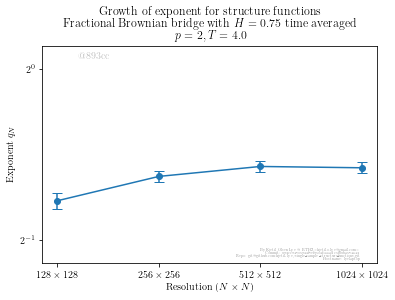

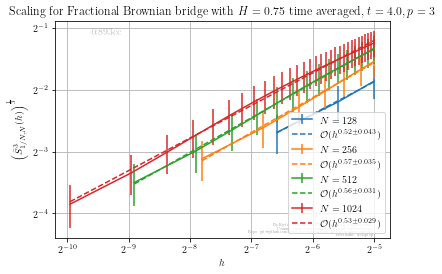

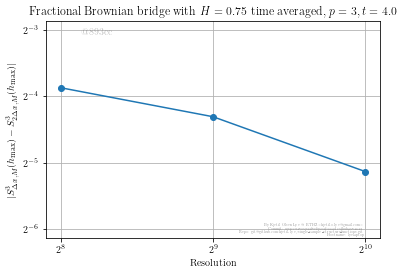

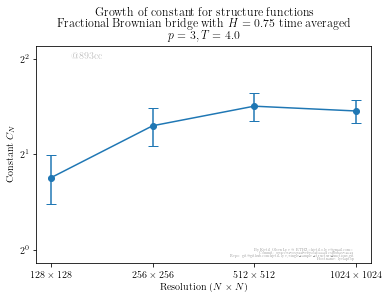

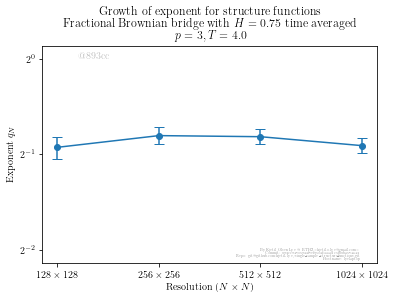

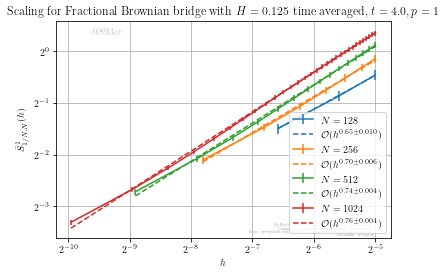

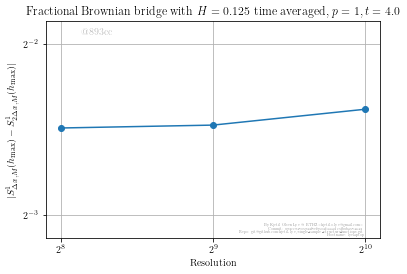

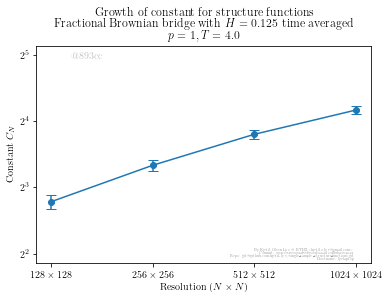

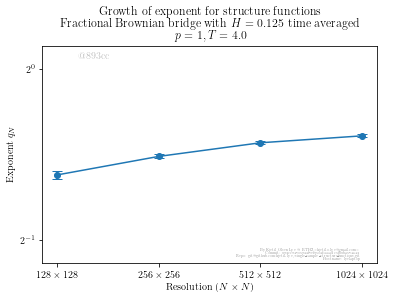

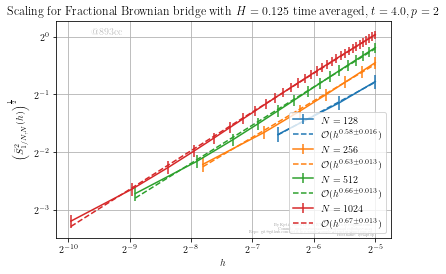

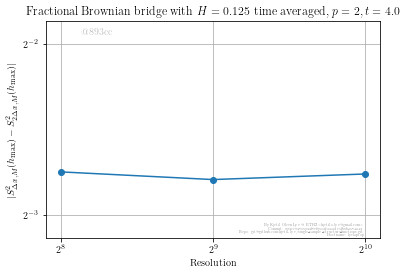

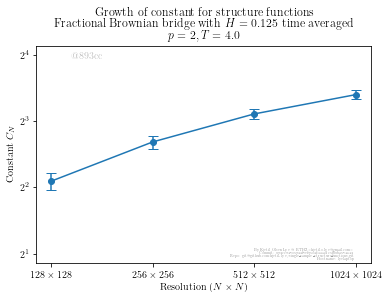

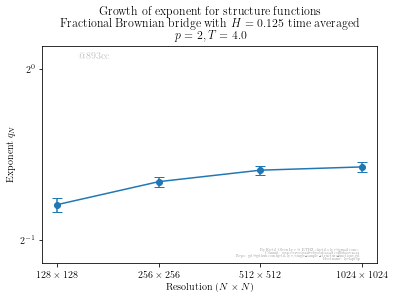

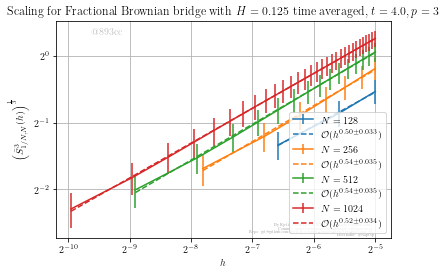

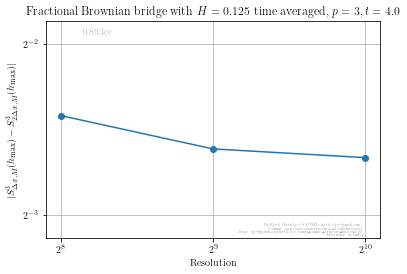

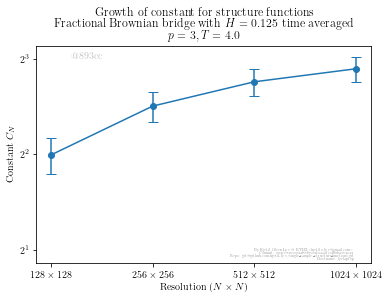

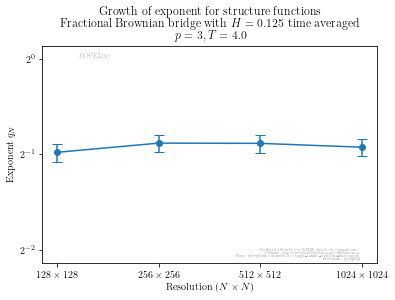

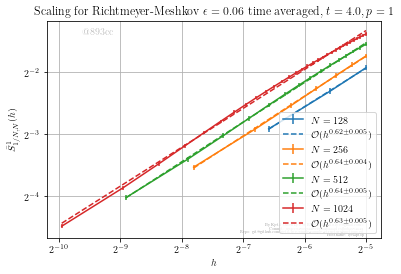

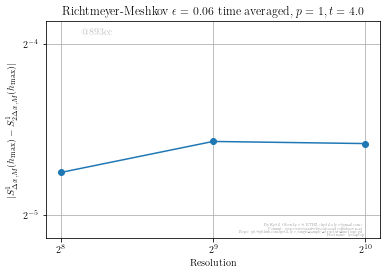

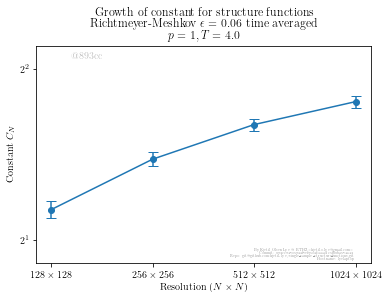

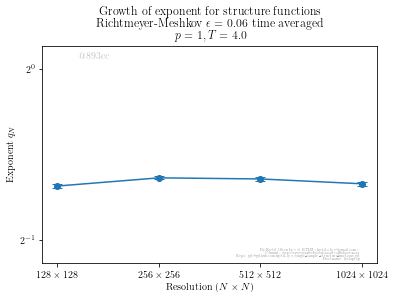

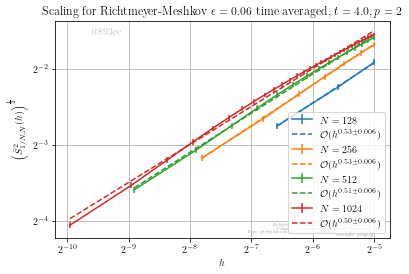

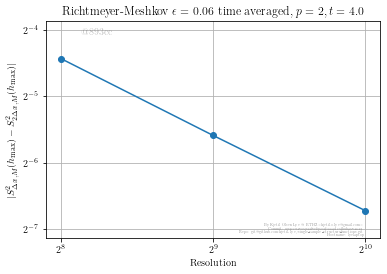

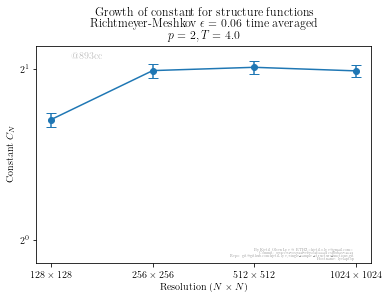

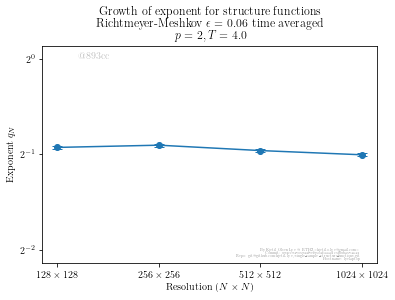

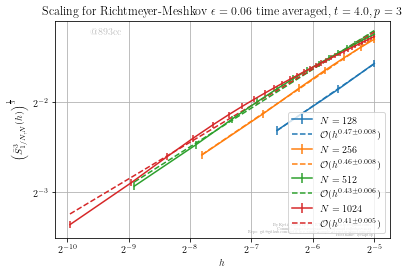

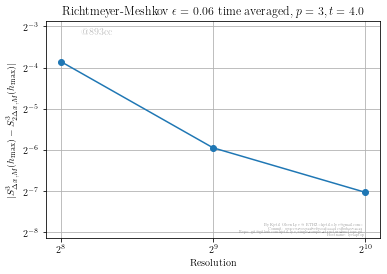

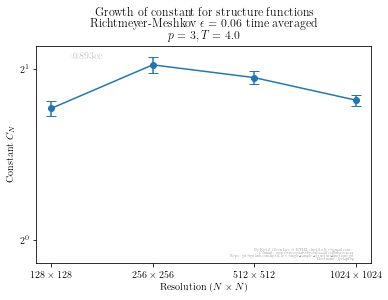

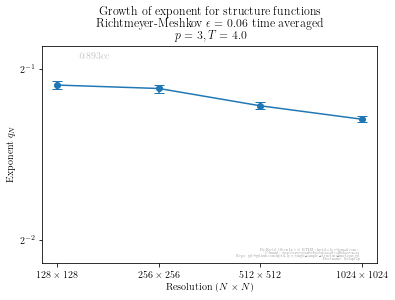

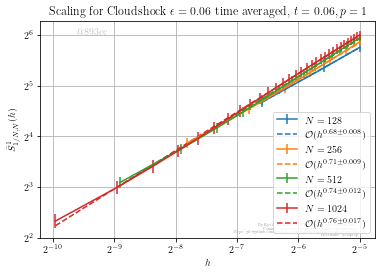

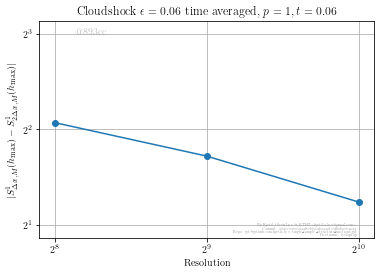

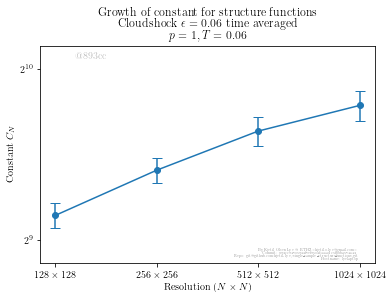

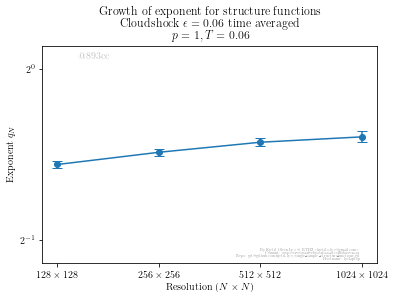

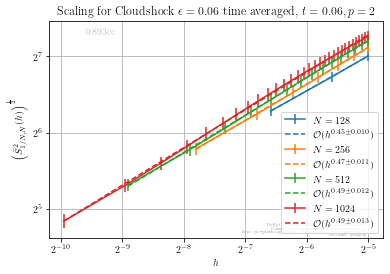

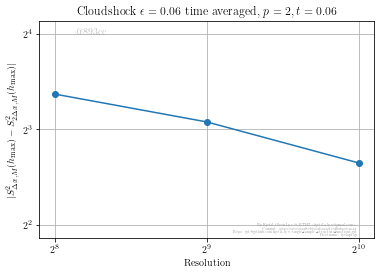

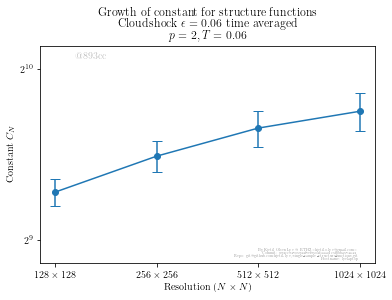

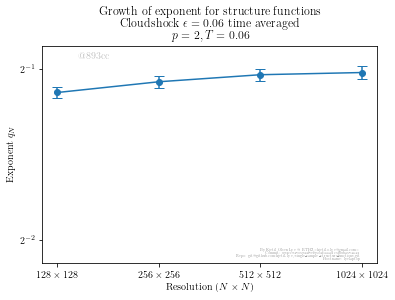

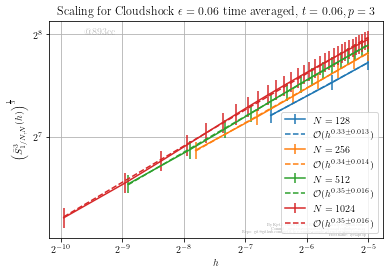

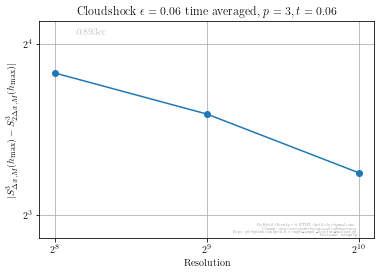

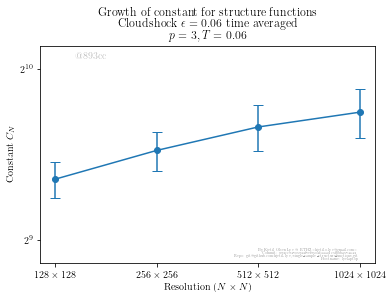

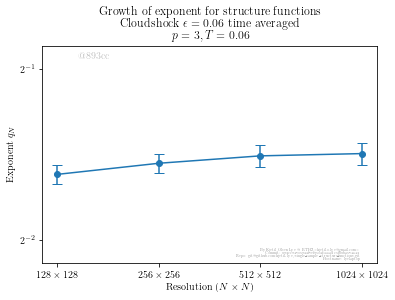

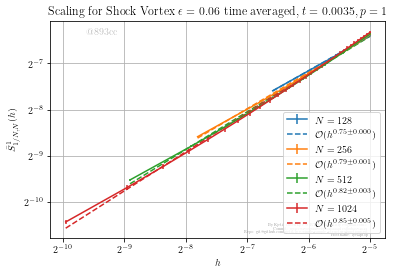

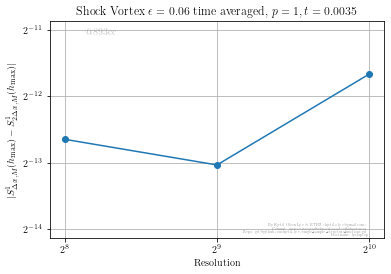

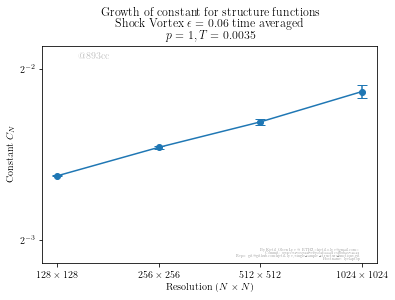

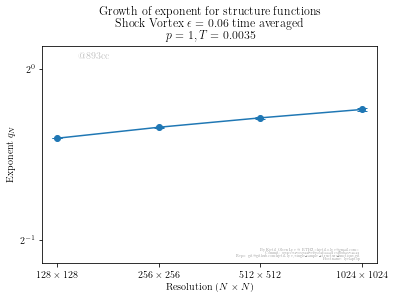

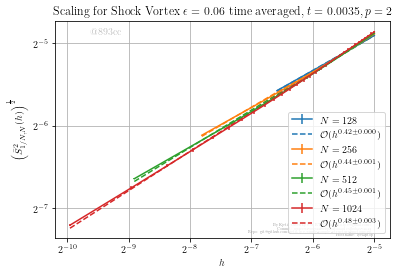

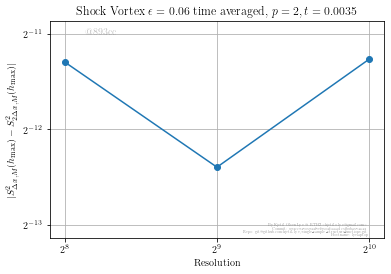

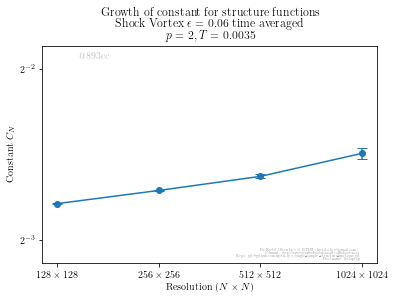

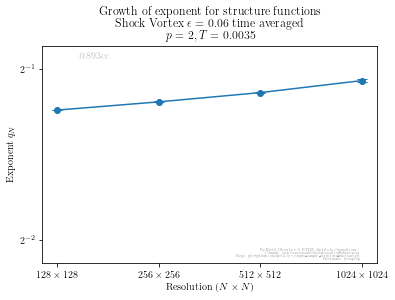

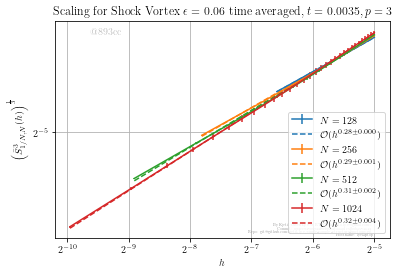

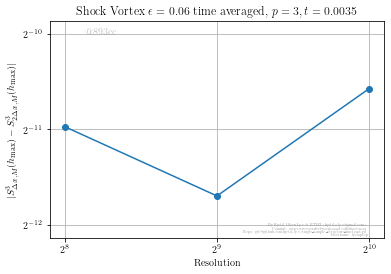

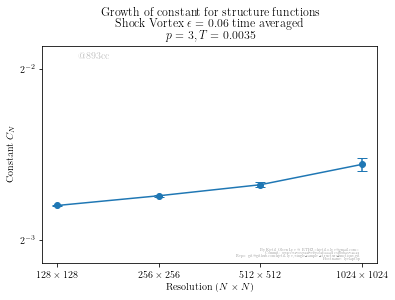

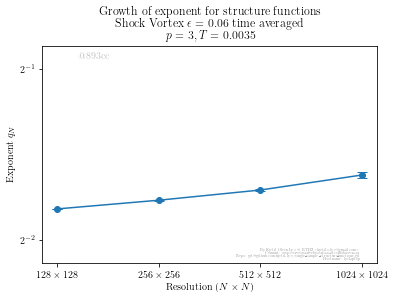

In [4]:
def convergence_structure_functions(config):
    headline("Component convergence Box averaged structure functions")
    variables = ['rho', 'mx','my', 'E']
    perturbations = config['perturbations']
    Tarray = config['Tarray']
    resolutions = config['resolutions']
    cube_filename = config['cube_filename']
    name = config['name']
    maxT = config['maxT']
    for perturbation in perturbations:
        h2("perturbation = %.2f" % perturbation)
        for p in [1,2,3]:
            h3("p = %d" % p)
            timeArray = Tarray
                
            for t in timeArray:
                

                errors = np.zeros(len(resolutions)-1)

                constants_mean = []
                constants_variance = []
                
                exponents_mean = []
                exponents_variance = []
                for (nr, resolution) in enumerate(resolutions):        
                    filename = cube_filename.format(perturbation = perturbation, p=p,t=t,resolution=resolution)
                     
                    time = get_time(filename)
                    if nr == 0:
                        h4("t = %f" % time)
                    structure_mean, structure_variance, constant_mean, constant_variance, exponent_mean, exponent_var = getlineintegral(filename, variables, resolution, p)
                    

                    if resolution > resolutions[0]:
                        errors[nr-1] = abs(structure_mean[-1]-structure_mean_prev[-1])
                    structure_mean_prev = np.repeat(structure_mean,2,0)
                   
                    if len(perturbations) > 1:
                        title = f'Scaling for {name}, $t={time},p={p},\\varepsilon={perturbation}$'
                    else:
                        title = f'Scaling for {name}, $t={time},p={p}$'

                    plotscalings(structure_mean, structure_variance, resolution, title, 
                                 exponent_mean, exponent_var)
                    
                    plt.xlabel('$h$')
                    if p != 1:
                        plt.ylabel('$\\left(\\bar{S}^{%d}_{1/N,N}(h)\\right)^{\\frac{1}{%d}}$' % (p,p))
                    else:
                        
                        plt.ylabel('$\\bar{S}^{%d}_{1/N,N}(h)$' % (p))
                        
                    constants_mean.append(constant_mean)
                    constants_variance.append(constant_variance)
                    
                    
                    exponents_mean.append(exponent_mean)
                    exponents_variance.append(exponent_var)
                for nr in range(len(resolutions)-1):
                    errors[nr] = abs(errors[nr])
                    
                legend_fixed_right()

                showAndSave('scaling_mean_var_{name}_{p}_{perturbation}_{time}'.format(name=name.replace('$','').replace(' ',"_").replace('=',''), p=p, perturbation=perturbation, time=t))
                plt.loglog(resolutions[1:],errors, '-o', basex=2, basey=2)
                
                plt.ylim([2.0**(np.floor(np.log2(min(errors))))/1.1, 1.1*2.0**(np.ceil(np.log2(max(errors))))])
                if len(perturbations)>1:
                    title = f'{name}, $p={p}, t={time}, \\varepsilon={perturbation}$'
                else:
                    title = f'{name}, $p={p}, t={time}$'

                plt.title(title)
                plt.xlabel('Resolution')
                plt.ylabel('$|S^{%d}_{\Delta x,M}(h_{\\max})-S^{%d}_{2\Delta x,M}(h_{\\max})|$' % (p,p) )
                plt.grid(True)
                showAndSave('structure_convergence_{name}_{p}_{perturbation}_{time}'.format(name=name.replace('$','').replace(' ',"_").replace('=',''), p=p, perturbation=perturbation, time=t))
                
                
                plt.errorbar(resolutions, constants_mean, yerr=np.sqrt(constants_variance), fmt='-o',
                             solid_capstyle='projecting', capsize=5)
                plt.ylim([2.0**(np.floor(np.log2(min(constants_mean-np.sqrt(constants_variance)))))/1.1,
                          1.1*2.0**(np.ceil(np.log2(max(constants_mean-np.sqrt(constants_variance)))))])
                
                plt.xscale('log', basex=2)
                plt.yscale('log', basey=2)
                plt.xlabel('Resolution ($N\\times N$)')
                plt.ylabel('Constant $C_N$')
                
                plt.xticks(resolutions, [f'${N}\\times {N}$' for N in resolutions])
                plt.title(f"Growth of constant for structure functions\n{name}\n$p={p}, T={time}$")
                plot_info.showAndSave(f'structure_constants_{name}_{p}_{perturbation}_{time}')
                
                plt.errorbar(resolutions, exponents_mean, yerr=np.sqrt(exponents_variance), fmt='-o',
                             solid_capstyle='projecting', capsize=5)
                
                
                plt.ylim([2.0**(np.floor(np.log2(min(exponents_mean-np.sqrt(exponents_variance)))))/1.1,
                          1.1*2.0**(np.ceil(np.log2(max(exponents_mean-np.sqrt(exponents_variance)))))])
                
                
                plt.xscale('log', basex=2)
                plt.yscale('log', basey=2)
                plt.xlabel('Resolution ($N\\times N$)')
                plt.ylabel('Exponent $q_N$')
                plt.title(f"Growth of exponent for structure functions\n{name}\n$p={p}, T={time}$")
                plt.xticks(resolutions, [f'${N}\\times {N}$' for N in resolutions])
                plot_info.showAndSave(f'structure_exponents_{name}_{p}_{perturbation}_{time}')
                
                             
for_each_config(convergence_structure_functions)

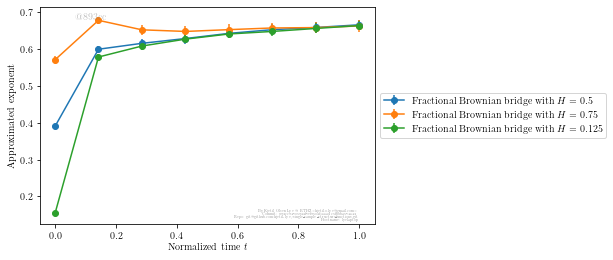

In [14]:
import collections
# for each name / title, for each p

all_mean_exponents = collections.defaultdict(lambda: collections.defaultdict(list))
all_std_exponents = collections.defaultdict(lambda: collections.defaultdict(list))
def time_evolution_structure_functions(config):
    
    if 'time averaged' in config['name'].lower():
        return
    
    if 'short time' in config['name'].lower():
        return
    
    headline("Time evolution of the structure functions")
    variables = ['rho', 'mx','my', 'E']
    perturbations = config['perturbations']
    Tarray = config['Tarray']
    resolutions = config['resolutions']
    cube_filename = config['cube_filename']
    name = config['name']
    maxT = config['maxT']
    for perturbation in perturbations:
        h2("perturbation = %.2f" % perturbation)
        for p in [1,2,3]:
            h3("p = %d" % p)
            timeArray = list(range(0, max(Tarray)))
            
            for t in timeArray:
                
                filename = cube_filename.format(perturbation = perturbation, p=p,t=t,resolution=resolutions[-1])
                 
                time = get_time(filename)

                structure_mean, structure_variance, _,_, exponent_mean, exponent_var = \
                    getlineintegral(filename, variables, resolutions[-1], p)
                
                
                N = len(structure_mean)
                H = np.linspace(0, 64./2048,N)
   
                poly = np.polyfit(np.log(H[1:]), np.log(structure_mean[1:]),1)
                    
                all_mean_exponents[name][p].append(poly[0])
                all_std_exponents[name][p].append(np.sqrt(exponent_var))

for_each_config(time_evolution_structure_functions)

configurations_with_exponents = list(all_mean_exponents.keys())
Ps = sorted(list(all_mean_exponents[configurations_with_exponents[0]]))


for p in Ps:
    for configuration in configurations_with_exponents:
        t = np.linspace(0, 1, len(all_mean_exponents[configuration][p]))
        
        plt.errorbar(t, all_mean_exponents[configuration][p], 
                     yerr = all_std_exponents[configuration][p],
                    label=configuration, fmt='-o')
    plt.legend()
    plt.xlabel("Normalized time $t$")
    plt.ylabel("Approximated exponent")
    plot_info.legendLeft()
    
    plot_info.showAndSave(f"time_evolution_structure_{p}")
    
        

TypeError: object of type 'numpy.float64' has no len()